In [1]:
import ott
import jax
from ott.neural import datasets
from ott.neural.methods.flows import dynamics, otfm
from ott.neural.networks.layers import time_encoder
from ott.neural.networks.velocity_field import VelocityField
from ott.solvers import utils as solver_utils
from ott.neural.methods.flows.genot import GENOT
from torch.utils.data import DataLoader
import jax.numpy as jnp
from typing import Literal, Optional, Any
import scanpy as sc
import functools
import optax
import moscot
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing as pp
from ott.solvers.linear import sinkhorn, acceleration
import anndata

In [2]:
adata_atc_train_src = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_src_atac_train_processed_peakvi.h5ad")
adata_atac_train_tgt = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_tgt_train_processed_peakvi.h5ad")

In [3]:
source_train = adata_atc_train_src.obsm["X_peakVI"]
target_train = adata_atac_train_tgt.obsm["X_peakVI"]

In [4]:
def data_match_fn(
    src_lin: Optional[jnp.ndarray],
    tgt_lin: Optional[jnp.ndarray],
    src_quad: Optional[jnp.ndarray],
    tgt_quad: Optional[jnp.ndarray],
    *,
    typ: Literal["lin", "quad", "fused"],
    epsilon: float = 1e-2,
    tau_a: float = 0.999,
    tau_b: float = 0.999,
    **kwargs: Any,
) -> jnp.ndarray:
        
    if typ == "lin":
        return solver_utils.match_linear(
            x=src_lin, y=tgt_lin, scale_cost="mean", epsilon=epsilon, tau_a=tau_a, tau_b=tau_b, **kwargs
        )
    if typ == "quad":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad, scale_cost="mean", **kwargs)
    if typ == "fused":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad, x=src_lin, y=tgt_lin, scale_cost="mean", **kwargs)
    raise NotImplementedError(f"Unknown type: {typ}.")

In [5]:
source_dim = source_train.shape[1]
target_dim = source_train.shape[1]

In [6]:
dl = DataLoader(datasets.OTDataset(datasets.OTData(lin=source_train), datasets.OTData(lin=target_train)),
            batch_size=1024,
            shuffle=True,
        )

In [7]:
vf = VelocityField(
    hidden_dims=[1024, 1024, 1024],
    time_dims=[1024, 1024, 1024],
    output_dims=[1024, 1024, 1024] + [target_dim],
    condition_dims=[1024, 1024, 1024],
    time_encoder=functools.partial(time_encoder.cyclical_time_encoder, n_freqs=1024),
)

In [8]:

match_fn = jax.jit(
            functools.partial(
                data_match_fn,
                typ="lin",
                epsilon=1e-2,
                tau_a=0.999, 
                tau_b=0.999, 
                )
        )

In [9]:
model = GENOT(vf, 
     flow=dynamics.ConstantNoiseFlow(0.0), 
     data_match_fn = match_fn,
     source_dim=source_dim,
     target_dim=target_dim,
     optimizer = optax.adam(learning_rate=1e-4),
     rng=jax.random.PRNGKey(0))

In [10]:
from typing import Dict, Tuple
from tqdm import tqdm
import jax.tree_util as jtu


def prepare_data(
    batch: Dict[str, jnp.ndarray]
) -> Tuple[Tuple[jnp.ndarray, Optional[jnp.ndarray], jnp.ndarray],
           Tuple[jnp.ndarray, jnp.ndarray, Optional[jnp.ndarray],
                 Optional[jnp.ndarray]]]:
  src_lin, src_quad = batch.get("src_lin"), batch.get("src_quad")
  tgt_lin, tgt_quad = batch.get("tgt_lin"), batch.get("tgt_quad")

  if src_quad is None and tgt_quad is None:  # lin
    src, tgt = src_lin, tgt_lin
    arrs = src_lin, tgt_lin, None, None
  elif src_lin is None and tgt_lin is None:  # quad
    src, tgt = src_quad, tgt_quad
    arrs = None, None, src_quad, tgt_quad
  elif all(
      arr is not None for arr in (src_lin, tgt_lin, src_quad, tgt_quad)
  ):  # fused quad
    src = jnp.concatenate([src_lin, src_quad], axis=1)
    tgt = jnp.concatenate([tgt_lin, tgt_quad], axis=1)
    arrs = src_lin, tgt_lin, src_quad, tgt_quad
  else:
    raise RuntimeError("Cannot infer OT problem type from data.")

  return (src, batch.get("src_condition"), tgt), arrs

In [11]:
training_logs = {"loss": []}

In [12]:
NUM_ITER = 10000


rng = jax.random.PRNGKey(0)

for it in tqdm(range(NUM_ITER)):
  rng = jax.random.split(rng, 5)
  rng, rng_resample, rng_noise, rng_time, rng_step_fn = rng

  batch = next(iter(dl))
  batch = jtu.tree_map(jnp.asarray, batch)
  (src, src_cond, tgt), matching_data = prepare_data(batch)

  n = src.shape[0]
  time = model.time_sampler(rng_time, n * model.n_samples_per_src)
  latent = model.latent_noise_fn(rng_noise, (n, model.n_samples_per_src))

  tmat = model.data_match_fn(*matching_data)  # (n, m)
  if np.isnan(tmat).sum()>0:
      print("not converged")
      continue
  src_ixs, tgt_ixs = solver_utils.sample_conditional(  # (n, k), (m, k)
      rng_resample,
      tmat,
      k=model.n_samples_per_src,
  )

  src, tgt = src[src_ixs], tgt[tgt_ixs]  # (n, k, ...),  # (m, k, ...)
  if src_cond is not None:
    src_cond = src_cond[src_ixs]

  if model.latent_match_fn is not None:
    src, src_cond, tgt = model._match_latent(rng, src, src_cond, latent, tgt)

  src = src.reshape(-1, *src.shape[2:])  # (n * k, ...)
  tgt = tgt.reshape(-1, *tgt.shape[2:])  # (m * k, ...)
  latent = latent.reshape(-1, *latent.shape[2:])
  if src_cond is not None:
    src_cond = src_cond.reshape(-1, *src_cond.shape[2:])

  loss, model.vf_state = model.step_fn(
      rng_step_fn, model.vf_state, time, src, tgt, latent, src_cond
  )

  training_logs["loss"].append(float(loss))



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [22:08<00:00,  7.53it/s]


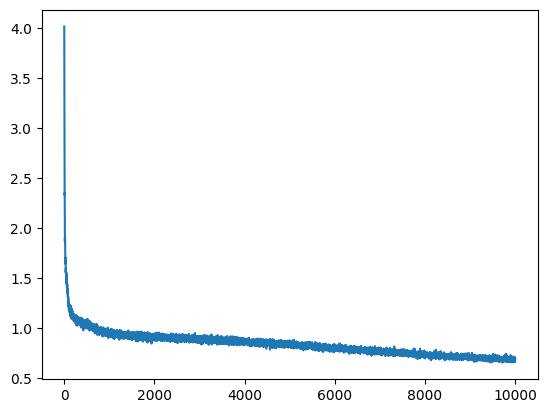

In [13]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(training_logs["loss"])), training_logs["loss"])

# the training looks

In [14]:
adata_atac_test_src = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_arc_atac_test_processed_peakvi.h5ad")
adata_atac_test_tgt = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_tgt_test_processed_peakvi.h5ad")

In [15]:
source_test = adata_atac_test_src.obsm["X_peakVI"]
target_test = adata_atac_test_tgt.obsm["X_peakVI"]

In [16]:
transported = model.transport(source_test, rng=jax.random.PRNGKey(0))

In [17]:
adata_source_test = adata_atac_test_src
adata_target_test = adata_atac_test_tgt

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/

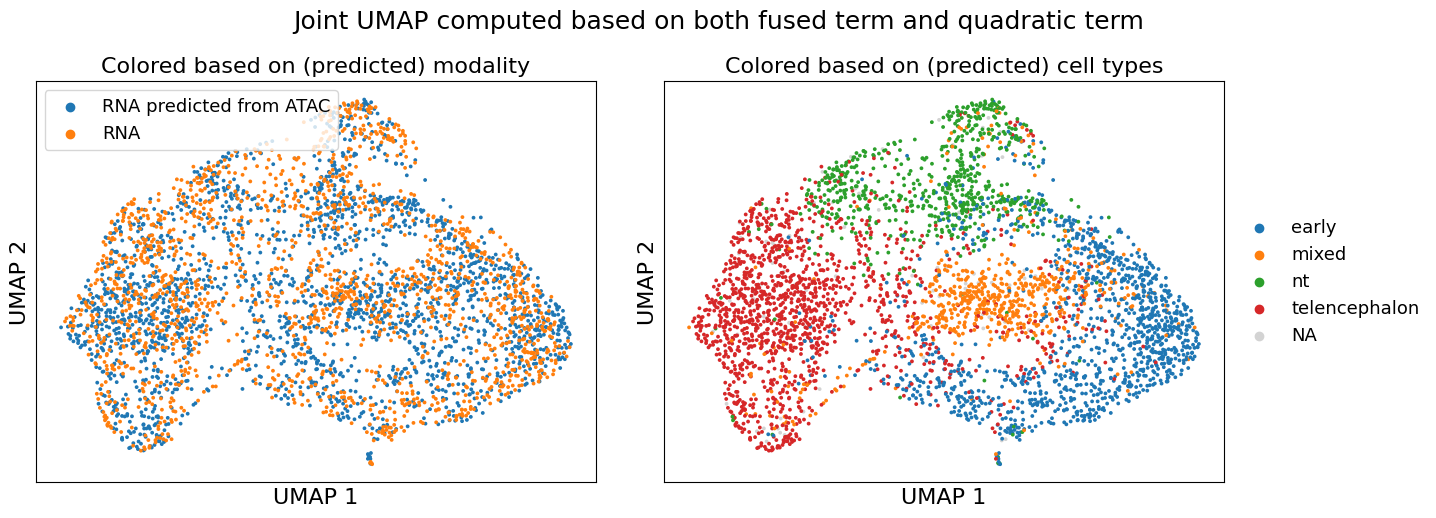

In [18]:
adata_one_sample = sc.concat(
    [adata_source_test, adata_target_test],
    join="outer",
    label="batch",
    keys=["RNA predicted from ATAC", "RNA"],
)
adata_one_sample.obsm["X_translated_0"] = np.concatenate(
    (transported, target_test), axis=0
)
sc.pp.neighbors(adata_one_sample, use_rep="X_translated_0")
sc.tl.umap(adata_one_sample)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Joint UMAP computed based on both fused term and quadratic term", size=18, y=0.9)
sc.pl.umap(adata_one_sample, color=["batch"], ax=ax1, show=False, size=30, legend_fontsize=10)
ax1.legend()
ax1.set_title("Colored based on (predicted) modality", fontsize=16)
ax1.set_xlabel('UMAP 1', fontsize=16)
ax1.set_ylabel('UMAP 2', fontsize=16)
sc.pl.umap(adata_one_sample, color=["branch"], ax=ax2, show=False, size=30, legend_fontsize=13)
ax2.set_title("Colored based on (predicted) cell types", fontsize=16)
ax2.set_xlabel('UMAP 1', fontsize=16)
ax2.set_ylabel('UMAP 2', fontsize=16)
ax1.legend(fontsize=13)
plt.tight_layout(pad=3.0)
plt.show()

In [19]:
tr = []
for i in range(10):
    tr.append(model.transport(source_test, rng=jax.random.PRNGKey(i)))
tr_arr = np.array(tr)
trans = tr_arr.mean(axis=0)

In [20]:
for i in range(10):
    adata_atac_test_src.obsm[f"predicted_atac_{i}"] = tr_arr[i]

In [21]:
adata_atac_test_src.write("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_src_atac_with_predictions_peakVI.h5ad")

In [22]:
tr = []
for i in range(10):
    tr.append(model.transport(source_test, rng=jax.random.PRNGKey(i)))
tr_arr = np.array(tr)
trans = tr_arr.mean(axis=0)

In [23]:
for i in range(10):
    adata_atac_test_src.obsm[f"predicted_atac_{i}"] = tr_arr[i]

In [24]:
adata_atac_test_src.write("/lustre/groups/ml01/workspace/ot_perturbation/data/multiome/GLI3_KO_multiome_18d_adata_src_atac_with_predictions_peakVI.h5ad")